k	RMSE_PCR	RMSE_PLSR
1	1.5170		1.3918
2	1.4928		1.2490
3	1.4990		1.0808
4	1.5128		1.0636
5	1.0647		1.0888
6	1.0657		1.1939
7	1.0766		1.3385
8	1.0720		1.4349
9	1.0726		1.5294
10	1.0745		1.6027

Best PCR:  k=5,  CV RMSE=1.0647
Best PLSR: k=4, CV RMSE=1.0636


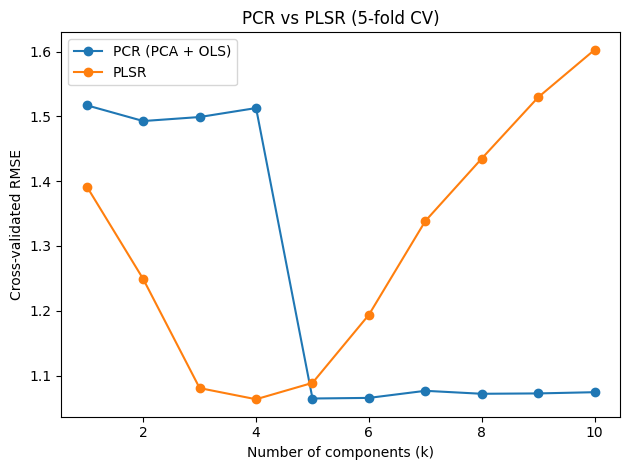

In [1]:
"""
PCR vs PLSR on synthetic data where y depends on a lower-variance factor.

Requirements:
  - numpy
  - scikit-learn
  - matplotlib
(Optional: pandas only if you want to export the table.)

What it does:
  1) Simulates X with r latent factors (descending variance).
  2) Constructs y from the *lowest-variance* factor + noise.
  3) Compares PCR (PCA -> LinearRegression) vs PLSRegression
     across k components using 5-fold CV.
  4) Prints CV RMSE and plots RMSE vs k.
"""

import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
RNG_SEED = 42
N_SAMPLES = 120     # number of samples (n)
N_FEATURES = 80     # number of features (p)
N_FACTORS = 5       # latent factors that generate X
MAX_K = 10          # evaluate components k=1..MAX_K
X_NOISE = 0.3       # noise in X
Y_NOISE = 1.0       # noise in y
N_SPLITS = 5        # KFold splits for CV

# -----------------------------
# Helpers
# -----------------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# -----------------------------
# 1) Simulate data
# -----------------------------
rng = np.random.default_rng(RNG_SEED)

# latent factors with descending variance (first has highest variance)
factor_scales = np.array([3.0, 2.0, 1.5, 1.0, 0.5])[:N_FACTORS]

F = rng.normal(size=(N_SAMPLES, N_FACTORS)) * factor_scales  # (n x r)
A = rng.normal(size=(N_FEATURES, N_FACTORS))                 # (p x r) loadings

X = F @ A.T + rng.normal(scale=X_NOISE, size=(N_SAMPLES, N_FEATURES))

# y depends mainly on the *lowest-variance* factor (index -1)
y = 2.0 * F[:, -1] + rng.normal(scale=Y_NOISE, size=N_SAMPLES)

# -----------------------------
# 2) Build estimators
# -----------------------------
# PCR: Standardize -> PCA(k) -> OLS, implemented via Pipeline (so CV fits PCA on train folds only)
def make_pcr_pipeline(k):
    return Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("pca", PCA(n_components=k, svd_solver="full", random_state=RNG_SEED)),
        ("lr", LinearRegression())
    ])

# PLSR: scales X and y internally when scale=True
def make_pls(k):
    return PLSRegression(n_components=k, scale=True, max_iter=500)

# -----------------------------
# 3) Cross-validated comparison across k
# -----------------------------
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RNG_SEED)

ks = list(range(1, MAX_K + 1))
rmse_pcr = []
rmse_pls = []

for k in ks:
    # PCR
    pcr = make_pcr_pipeline(k)
    yhat_pcr = cross_val_predict(pcr, X, y, cv=kf)          # predictions across folds
    rmse_pcr.append(rmse(y, yhat_pcr))

    # PLSR
    pls = make_pls(k)
    yhat_pls = cross_val_predict(pls, X, y, cv=kf).ravel()   # PLS returns 2D; flatten
    rmse_pls.append(rmse(y, yhat_pls))

# -----------------------------
# 4) Print table
# -----------------------------
print("k\tRMSE_PCR\tRMSE_PLSR")
for k, r_pcr, r_pls in zip(ks, rmse_pcr, rmse_pls):
    print(f"{k}\t{r_pcr:.4f}\t\t{r_pls:.4f}")

best_pcr_k = ks[int(np.argmin(rmse_pcr))]
best_pls_k = ks[int(np.argmin(rmse_pls))]
print(f"\nBest PCR:  k={best_pcr_k},  CV RMSE={min(rmse_pcr):.4f}")
print(f"Best PLSR: k={best_pls_k}, CV RMSE={min(rmse_pls):.4f}")

# -----------------------------
# 5) Plot RMSE vs k
# -----------------------------
plt.figure()
plt.plot(ks, rmse_pcr, marker="o", label="PCR (PCA + OLS)")
plt.plot(ks, rmse_pls, marker="o", label="PLSR")
plt.xlabel("Number of components (k)")
plt.ylabel("Cross-validated RMSE")
plt.title("PCR vs PLSR (5-fold CV)")
plt.legend()
plt.tight_layout()
plt.show()


Angle between PCA and PLSR directions: 86.48 degrees
corr(t_PCA, y): 0.012
corr(t_PLS, y): -0.421


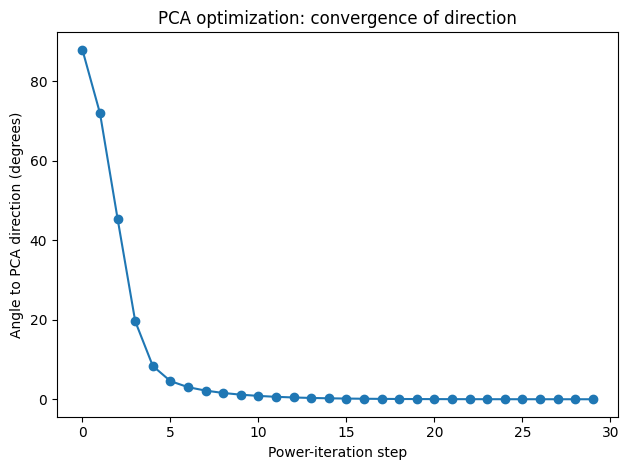

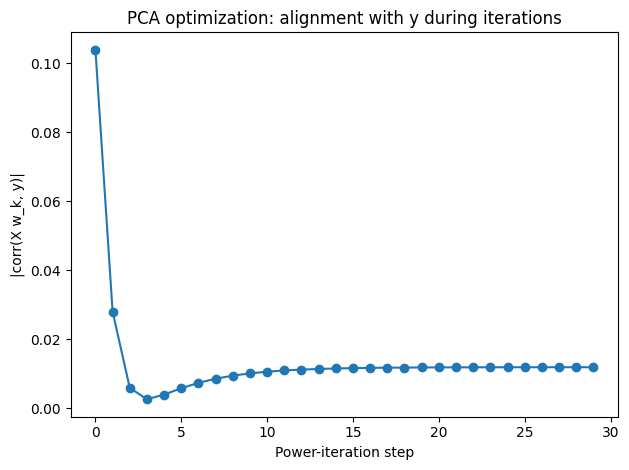

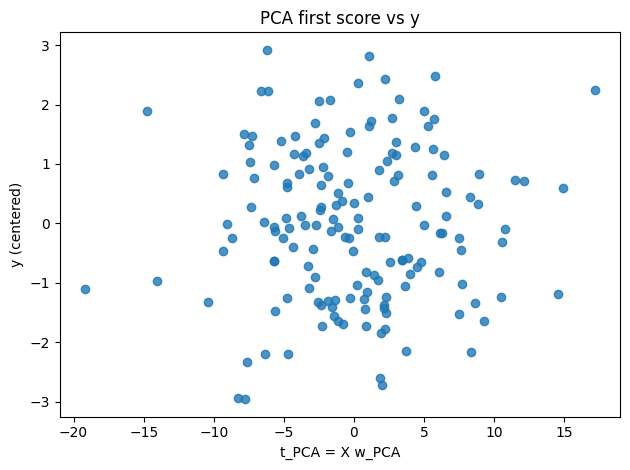

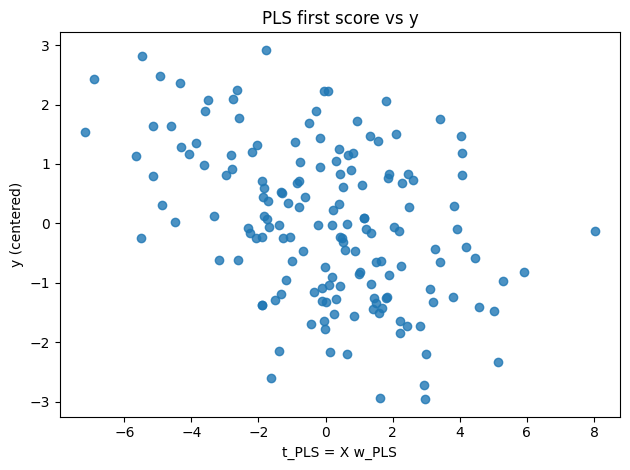

In [2]:
"""
Visualize PCA's alignment with y during optimization, and compare PCA vs PLSR directions.

What you get:
  (1) Angle to the converged PCA direction over power-iteration steps
  (2) |corr(X w_k, y)| during those steps (alignment with y)
  (3) Scatter: t_PCA = X w_PCA  vs y
  (4) Scatter: t_PLS = X w_PLS  vs y
  + Printed: angle between PCA and PLS first directions, and their correlations with y

Requires: numpy, scikit-learn, matplotlib
"""

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

# -----------------------------
# Utilities
# -----------------------------
def unit(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def angle_degrees(u, v):
    """Absolute angle in degrees between two vectors (0..90)."""
    c = np.clip(np.dot(unit(u), unit(v)), -1.0, 1.0)
    return float(np.degrees(np.arccos(abs(c))))

# -----------------------------
# 1) Simulate data (y from a low-variance factor)
# -----------------------------
rng = np.random.default_rng(7)
n, p, r = 160, 80, 5

factor_scales = np.array([3.0, 2.0, 1.5, 1.0, 0.5])  # descending variance
F = rng.normal(size=(n, r)) * factor_scales          # latent factors (n x r)
A = rng.normal(size=(p, r))                          # loadings (p x r)
X_raw = F @ A.T + rng.normal(scale=0.3, size=(n, p)) # features
y = 2.0 * F[:, -1] + rng.normal(scale=1.0, size=n)   # response from lowest-variance factor

# Standardize X; center y for correlation/plots
X = StandardScaler().fit_transform(X_raw)
y_centered = y - y.mean()

# -----------------------------
# 2) PCA first component (converged solution)
# -----------------------------
pca = PCA(n_components=1, svd_solver="full", random_state=0)
pca.fit(X)
w_pca = pca.components_[0]             # (p,) unit vector
t_pca = X @ w_pca                      # scores

# -----------------------------
# 3) Track PCA optimization with simple power iteration
#    (on S = covariance of standardized X)
# -----------------------------
S = (X.T @ X) / (n - 1)                # covariance matrix
steps = 30
w = unit(rng.normal(size=p))           # random start
angles_deg = []
corrs_y = []

for _ in range(steps):
    # record angle to final PCA direction and correlation with y
    angles_deg.append(angle_degrees(w, w_pca))
    t = X @ unit(w)
    corrs_y.append(abs(np.corrcoef(t, y_centered)[0, 1]))
    # power iteration update
    w = S @ w

# -----------------------------
# 4) PLSR first component
# -----------------------------
pls = PLSRegression(n_components=1, scale=True, max_iter=500)
pls.fit(X, y_centered)
w_pls = unit(pls.x_weights_[:, 0])     # (p,) weight vector
t_pls = X @ w_pls

# -----------------------------
# 5) Numeric comparison
# -----------------------------
ang_pca_pls = angle_degrees(w_pca, w_pls)
corr_pca_y  = float(np.corrcoef(t_pca, y_centered)[0, 1])
corr_pls_y  = float(np.corrcoef(t_pls, y_centered)[0, 1])

print(f"Angle between PCA and PLSR directions: {ang_pca_pls:.2f} degrees")
print(f"corr(t_PCA, y): {corr_pca_y:.3f}")
print(f"corr(t_PLS, y): {corr_pls_y:.3f}")

# -----------------------------
# 6) Plots
# -----------------------------
# (a) Angle to PCA direction along power-iteration steps
plt.figure()
plt.plot(range(steps), angles_deg, marker="o")
plt.xlabel("Power-iteration step")
plt.ylabel("Angle to PCA direction (degrees)")
plt.title("PCA optimization: convergence of direction")
plt.tight_layout()

# (b) |corr(X w_k, y)| along power-iteration steps
plt.figure()
plt.plot(range(steps), corrs_y, marker="o")
plt.xlabel("Power-iteration step")
plt.ylabel("|corr(X w_k, y)|")
plt.title("PCA optimization: alignment with y during iterations")
plt.tight_layout()

# (c) PCA score vs y
plt.figure()
plt.scatter(t_pca, y_centered, alpha=0.8)
plt.xlabel("t_PCA = X w_PCA")
plt.ylabel("y (centered)")
plt.title("PCA first score vs y")
plt.tight_layout()

# (d) PLS score vs y
plt.figure()
plt.scatter(t_pls, y_centered, alpha=0.8)
plt.xlabel("t_PLS = X w_PLS")
plt.ylabel("y (centered)")
plt.title("PLS first score vs y")
plt.tight_layout()

plt.show()
